<a href="https://colab.research.google.com/github/traorekitio/Movie-genre-prediction-project/blob/main/ModelMovie_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prédiction genre de film

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re #traitement des caracteres spéciaux
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer #lemmatisation
from nltk.corpus import wordnet #synonyme
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from textblob import TextBlob #bibliothèque NLP pour l'analyse de sentiment d'un texte


In [4]:
# Charger le fichier texte dans un DataFrame
data = pd.read_csv('/content/train_data.txt', sep=' ::: ', engine='python', names=['ID', 'Title', 'Genre', 'Description'])

# Afficher les premières lignes du DataFrame
data.head()

,ID,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [5]:
data.shape

(54214, 4)

In [6]:
#Nombre total de films
print(f"Nombre total de films : {data['Title'].count()}")


Nombre total de films : 54214


In [7]:
#nombre de films uniques

nombre_films_uniques = data['Title'].nunique()
print(f"Nombre de films uniques : {nombre_films_uniques}")

Nombre de films uniques : 54214


In [8]:
#nombre de genres uniques

nombre_genres_uniques = data['Genre'].nunique()
print(f"Nombre de genres uniques : {nombre_genres_uniques}")

Nombre de genres uniques : 27


In [9]:
#Distribution des genres

# Compter la fréquence des genres
genre_counts = data['Genre'].value_counts()

print(genre_counts)

Genre
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
mystery          319
musical          277
biography        265
history          243
game-show        194
news             181
war              132
Name: count, dtype: int64


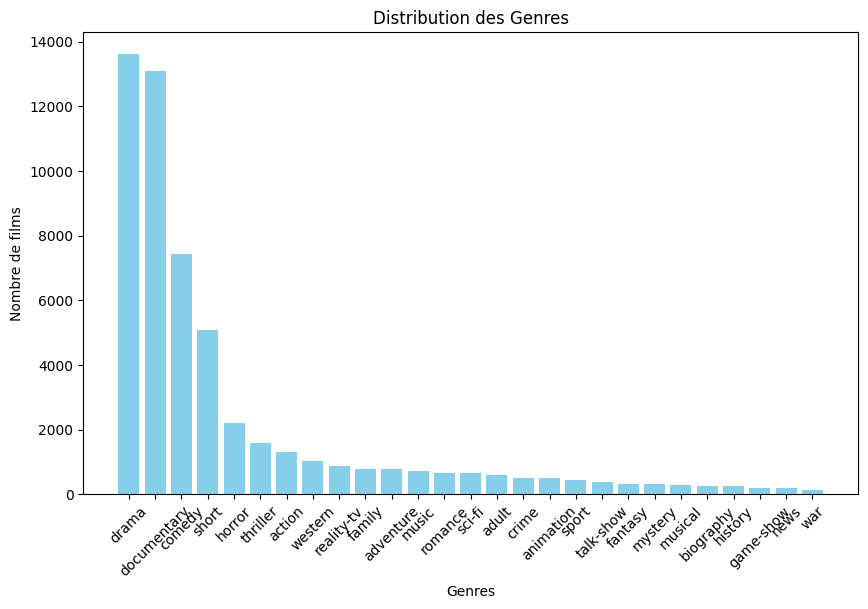

In [10]:
# Tracer la distribution des genres sous forme de diagramme en barres

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='skyblue')
plt.xlabel('Genres')
plt.ylabel('Nombre de films')
plt.title('Distribution des Genres')
plt.xticks(rotation=45)
plt.show()

Nous remarquons que certains genres tels que drama, documentary, comedy et short sont plus représentes que d'autres genres tels que history, game-show, news et wars. Il y'a donc un déséquilibre dans les classes. Il serait donc jusdicieux de traiter ce déséquilibre afin d'eviter que le modele penalise les classes moins representees. Les modeles de régression logistique et de SVM peuvent etre adaptés afin de donner plus d'importance aux classes minoritaires. Cependant d'autres modèles tels que Naive Bayes peuvent être utilisés mais en passant alors par le sur-échantillonnage des classes minoritaires ou le sous-échantillonnage des classes majoritaires.

In [11]:
# Vérifions si des films ont plusieurs genres

multiple_genres = data[data['Genre'].str.contains(',')]
print(multiple_genres)


Empty DataFrame
Columns: [ID, Title, Genre, Description]
Index: []


Ainsi aucun film n'est associé à plusieurs genres, cela rend le problème moins complexe car pas besoin d'avoir une approche multilabel.

# Nettoyage des données

## Valeurs manquantes

In [12]:
print(data.isnull().sum())


ID             0
Title          0
Genre          0
Description    0
dtype: int64


Il n'y a aucune valeurs manquante.

#Doublons


In [13]:
#Doublons

# Afficher les doublons dans la colonne 'Description'
duplicates_description = data[data.duplicated(subset='Description', keep=False)]

# Afficher le nombre de doublons trouvés
print(f"Nombre de doublons description trouvés : {duplicates_description.shape[0]}")

# Optionnel : Afficher les lignes contenant des doublons
print(duplicates_description)


Nombre de doublons description trouvés : 204
          ID                                     Title        Genre  \
59        60                     The Fatal Game (1997)  documentary   
403      404                "The Secret Garden" (1960)        drama   
521      522  Classic Rhythm and Blues Vol. 2 (1988/I)  documentary   
869      870      The 43rd Annual Grammy Awards (2001)        music   
1304    1305      The Houses with No Address (2015/II)  documentary   
...      ...                                       ...          ...   
52770  52771       The Houses with No Address (2015/I)  documentary   
53480  53481     The 63rd Annual Academy Awards (1991)       family   
53893  53894                  The Three Sisters (1981)        drama   
53965  53966                       Voskreseniye (1960)        drama   
54046  54047     The 71st Annual Academy Awards (1999)       family   

                                             Description  
59     In 1994, New Zealand mountaineer, Ma

In [14]:
#Doublons

# Afficher les doublons dans la colonne 'Description'
duplicates_film = data[data.duplicated(subset='Title', keep=False)]

# Afficher le nombre de doublons trouvés
print(f"Nombre de doublons films trouvés : {duplicates_film.shape[0]}")

# Optionnel : Afficher les lignes contenant des doublons
print(duplicates_film)

Nombre de doublons films trouvés : 0
Empty DataFrame
Columns: [ID, Title, Genre, Description]
Index: []


Nous trouvons 204 doublons au niveau des descriptions mais tous pour des titres de films differents car il n'y a aucun doublon au niveau des titres de films et on a vu plus haut qu'il y'a 5214 titres uniques correspondant au nombre de lignes de notre dataframe.

In [15]:
# Vérifions s'il y a des doublons qui ont des genres différents

# Ajouter une colonne avec les différents genres séparés par des virgules
different_genres = duplicates_description.groupby('Description').agg(
    Genres_Séparés=('Genre', lambda x: ', '.join(x.unique()))  # Nom de la colonne modifié ici
).reset_index()

# Ne garder que les descriptions avec plusieurs genres
different_genres = different_genres[different_genres['Genres_Séparés'].str.split(', ').str.len() > 1]

# Ajouter une colonne 'nombre_genres' qui compte le nombre de genres pour chaque description
different_genres['nombre_genres'] = different_genres['Genres_Séparés'].str.split(', ').str.len()

# Afficher le nombre de descriptions associées à plusieurs genres
print(f"Nombre de descriptions associées à plusieurs genres : {different_genres.shape[0]}")
print(different_genres)


Nombre de descriptions associées à plusieurs genres : 15
                                          Description  \
0   "People' s Choice Awards" - American award, th...   
1   'Louisa May Alcott' (qv)'s autobiographical ac...   
6   A retired professor has returned to his estate...   
8   A rich merchant, Antonio is depressed for no g...   
10  A young British girl born and raised in India ...   
15  Award of the American academy of cinematograph...   
18  Bosko Pavlovic AKA "Bole Kalifornija" (Dragan ...   
32  Grace has agreed to marry Sir Harcourt in retu...   
46  Lord Windermere appears to all - including to ...   
58  The Pickwick Club sends Mr. Pickwick and a gro...   
62  The hapless king of a small European nation mu...   
64  The poor ghost of Sir Simon Canterville has be...   
65  The young Gascon D'Artagnan arrives in Paris, ...   
72  Viola and Sebastian are lookalike twins, separ...   
75  When the Duke of Vienna takes a mysterious lea...   

                              

Nous remarquons que pour une meme description, il y'a plusieurs genres differents. Celà n'est pas logique. De même, une même description pour différents films pourrait biaiser le modèle. Nous allons donc supprimer les 204 doublons trouvés en gardant seulement une seule instance. Mais laquelle? Nous garderons celle la description contenant le nombre de synonymes le plus élevé pour le genre auquel il est associé. Celà inclus donc la création de nouvelles features.

# Traitement du langage naturel (NLP)

## Mise en minuscule

In [16]:
data['Description_clean'] = data['Description'].str.lower()

index = 0  # Choisissez l'index de la ligne à afficher
print("Avant nettoyage taille:", len(data.loc[index, 'Description']))
print(data.loc[index, 'Description'])

print("\nAprès nettoyage taille:", len(data.loc[index, 'Description_clean']))
print(data.loc[index, 'Description_clean'])


Avant nettoyage taille: 545
Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.

Après nettoyage taille: 545
listening in to a conversation between his doctor and parents, 10-year-old oscar learns what nobody has the courage to tell him. he only has a few weeks to live. furious, he refuses to speak to anyone except straight-talking rose, the lady in pink he meets on the hospital stairs. as christmas approaches, rose uses her fantastical experiences as a professional wrestler, her imagination, wit and 

## Suppression des caractères spéciaux et ponctuation

In [18]:
data['Description_clean'] = data['Description'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

index = 0  #index de la ligne à afficher
print("Avant nettoyage taille:", len(data.loc[index, 'Description']))
print(data.loc[index, 'Description'])

print("\nAprès nettoyage taille:", len(data.loc[index, 'Description_clean']))
print(data.loc[index, 'Description_clean'])


Avant nettoyage taille: 545
Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.

Après nettoyage taille: 529
Listening in to a conversation between his doctor and parents 10yearold Oscar learns what nobody has the courage to tell him He only has a few weeks to live Furious he refuses to speak to anyone except straighttalking Rose the lady in pink he meets on the hospital stairs As Christmas approaches Rose uses her fantastical experiences as a professional wrestler her imagination wit and charm to all

## Suppression des stopwords

In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

index = 0  #index de la ligne à afficher
print("Avant nettoyage taille:", len(data.loc[index, 'Description']))
print(data.loc[index, 'Description'])

print("\nAvant suppression stopwords taille:", len(data.loc[index, 'Description_clean']))
print(data.loc[index, 'Description_clean'])

data['Description_clean'] = data['Description_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))



print("\nAprès nettoyage taille:", len(data.loc[index, 'Description_clean']))
print(data.loc[index, 'Description_clean'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Avant nettoyage taille: 545
Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.

Avant suppression stopwords taille: 529
Listening in to a conversation between his doctor and parents 10yearold Oscar learns what nobody has the courage to tell him He only has a few weeks to live Furious he refuses to speak to anyone except straighttalking Rose the lady in pink he meets on the hospital stairs As Christmas approaches Rose uses her fantastical experiences as a professional wrestler her imagination wit and 

Nous sommes ainsi passé de 529 mots à 389 mots après avoir retiré les stopwords.

## Lemmatisation

In [20]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

index = 0  #index de la ligne à afficher
print("Avant nettoyage taille:", len(data.loc[index, 'Description']))
print(data.loc[index, 'Description'])

print("\nAvant lemmatisation taille:", len(data.loc[index, 'Description_clean']))
print(data.loc[index, 'Description_clean'])

data['Description_clean'] = data['Description_clean'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

print("\nAprès nettoyage taille:", len(data.loc[index, 'Description_clean']))
print(data.loc[index, 'Description_clean'])

[nltk_data] Downloading package wordnet to /root/nltk_data...


Avant nettoyage taille: 545
Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.

Avant lemmatisation taille: 389
Listening conversation doctor parents 10yearold Oscar learns nobody courage tell He weeks live Furious refuses speak anyone except straighttalking Rose lady pink meets hospital stairs As Christmas approaches Rose uses fantastical experiences professional wrestler imagination wit charm allow Oscar live life love full company friends Pop Corn Einstein Bacon childhood sweetheart Peggy Blue

Ap

# Feature Engineering

## Longueur des descriptions

In [21]:
#Longueur des descriptions

data['Description_Length'] = data['Description_clean'].apply(lambda x: len(x.split()))

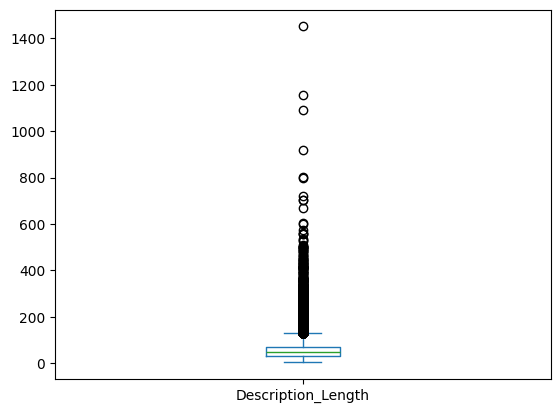

count    54214.000000
mean        60.707529
std         45.041870
min          4.000000
25%         33.000000
50%         47.000000
75%         72.000000
max       1451.000000
Name: Description_Length, dtype: float64


In [22]:
#visualisation des longueur des descriptions

data['Description_Length'].plot(kind="box")
plt.show()
print(data['Description_Length'].describe())

Nous remarquons déjà qu'il y'a une grande variation endtre les nombres de mots pour les differentes descrption avec un écart type de 45. Et celà s'appercoit également à travers le grand écart entre le minimum qui est à 4 et le maximum qui est à 1451.

In [23]:
# Afficher les descriptions dont la longueur est supérieure ou égale à 4
descriptions_min_length = data[data['Description_Length'] <= 4]

# Afficher quelques lignes du résultat
print(descriptions_min_length.head())


        ID                 Title  Genre  \
4754  4755  Buffalo Flats (????)  drama   

                                          Description       Description_clean  \
4754  Details of the plot are being kept under wraps.  Details plot kept wrap   

      Description_Length  
4754                   4  


Nous remarquons que malgré la courte description du film, il est possible de comprendre de quel genre il s'agit. Je ne vais donc pas supprimer les courtes descriptions car elles peuvent quand même être porteuses de sens.

## Features

In [24]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [25]:
def get_synonyms(word):
    """Cette fonction permet d'obtenir une liste des synonymes du mot entré en paramètre"""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower())
    return synonyms

In [26]:
def count_synonyms(description, keywords):
    """cette fonction permet d'avoir le nombre de synonymes du mot keywords entré en paramètre dans le document description"""
    count = 0
    words = description.lower().split()
    for word in words:
        synonyms = get_synonyms(word)
        for keyword in keywords:
            if keyword in synonyms or keyword == word:
                count += 1
    return count

In [27]:
data.head()

,ID,Title,Genre,Description,Description_clean,Description_Length
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,Listening conversation doctor parent 10yearold...,53
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,A brother sister past incestuous relationship ...,17
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,As bus empty student field trip Museum Natural...,59
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,To help unemployed father make end meet Edith ...,115
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,The film title refers unrecovered body ground ...,60


In [28]:
def get_genre_synonyms_count(row):
    """Cette fonction permet d'appliquer la fonction count_synonyms pour chaque description et genre"""
    genre_keywords = row['Genre'].lower().split()  # Obtenir les mots du genre
    return count_synonyms(row['Description_clean'], genre_keywords)

In [29]:
# Ajouter une colonne 'Genre_Synonyms_Count' au DataFrame
data['Genre_Synonyms_Count'] = data.apply(get_genre_synonyms_count, axis=1)

data.head()

,ID,Title,Genre,Description,Description_clean,Description_Length,Genre_Synonyms_Count
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,Listening conversation doctor parent 10yearold...,53,0
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,A brother sister past incestuous relationship ...,17,0
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,As bus empty student field trip Museum Natural...,59,0
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,To help unemployed father make end meet Edith ...,115,0
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,The film title refers unrecovered body ground ...,60,0


## Genre encoded

In [30]:
# Appliquer le One-Hot Encoding sur la colonne 'Genre'
data_one_hot = pd.get_dummies(data['Genre'], prefix='Genre').astype(int)
# Ajouter les colonnes encodées à ton DataFrame original
data = pd.concat([data, data_one_hot], axis=1)

# Afficher les premiers résultats
data.shape
data.head()

,ID,Title,Genre,Description,Description_clean,Description_Length,Genre_Synonyms_Count,Genre_action,Genre_adult,Genre_adventure,...,Genre_news,Genre_reality-tv,Genre_romance,Genre_sci-fi,Genre_short,Genre_sport,Genre_talk-show,Genre_thriller,Genre_war,Genre_western
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,Listening conversation doctor parent 10yearold...,53,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,A brother sister past incestuous relationship ...,17,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,As bus empty student field trip Museum Natural...,59,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,To help unemployed father make end meet Edith ...,115,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,The film title refers unrecovered body ground ...,60,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
print(f"Nombre de colonnes : {len(data.columns)}")
print(data.columns)


Nombre de colonnes : 34
Index(['ID', 'Title', 'Genre', 'Description', 'Description_clean',
       'Description_Length', 'Genre_Synonyms_Count', 'Genre_action',
       'Genre_adult', 'Genre_adventure', 'Genre_animation', 'Genre_biography',
       'Genre_comedy', 'Genre_crime', 'Genre_documentary', 'Genre_drama',
       'Genre_family', 'Genre_fantasy', 'Genre_game-show', 'Genre_history',
       'Genre_horror', 'Genre_music', 'Genre_musical', 'Genre_mystery',
       'Genre_news', 'Genre_reality-tv', 'Genre_romance', 'Genre_sci-fi',
       'Genre_short', 'Genre_sport', 'Genre_talk-show', 'Genre_thriller',
       'Genre_war', 'Genre_western'],
      dtype='object')


### Correlation entre les genres et les tailles des descriptions

In [32]:
# Calculer la corrélation entre les colonnes des genres et le nombre de mots
correlation_matrix = data[data_one_hot.columns.tolist() + ['Description_Length']].corr()

# Filtrer pour afficher uniquement la corrélation entre les genres et 'Description_Length'
correlation_with_length = correlation_matrix['Description_Length'].drop('Description_Length')

# Afficher les résultats
print(correlation_with_length)


Genre_action        -0.006523
Genre_adult         -0.024265
Genre_adventure     -0.014087
Genre_animation     -0.011536
Genre_biography      0.006256
Genre_comedy        -0.031054
Genre_crime         -0.007180
Genre_documentary    0.059984
Genre_drama          0.032950
Genre_family        -0.002071
Genre_fantasy       -0.004404
Genre_game-show      0.025168
Genre_history       -0.000220
Genre_horror         0.001324
Genre_music         -0.000423
Genre_musical       -0.001447
Genre_mystery        0.008601
Genre_news          -0.012623
Genre_reality-tv    -0.016955
Genre_romance        0.010473
Genre_sci-fi        -0.012433
Genre_short         -0.080105
Genre_sport          0.000338
Genre_talk-show     -0.015582
Genre_thriller      -0.009372
Genre_war            0.006769
Genre_western        0.033199
Name: Description_Length, dtype: float64


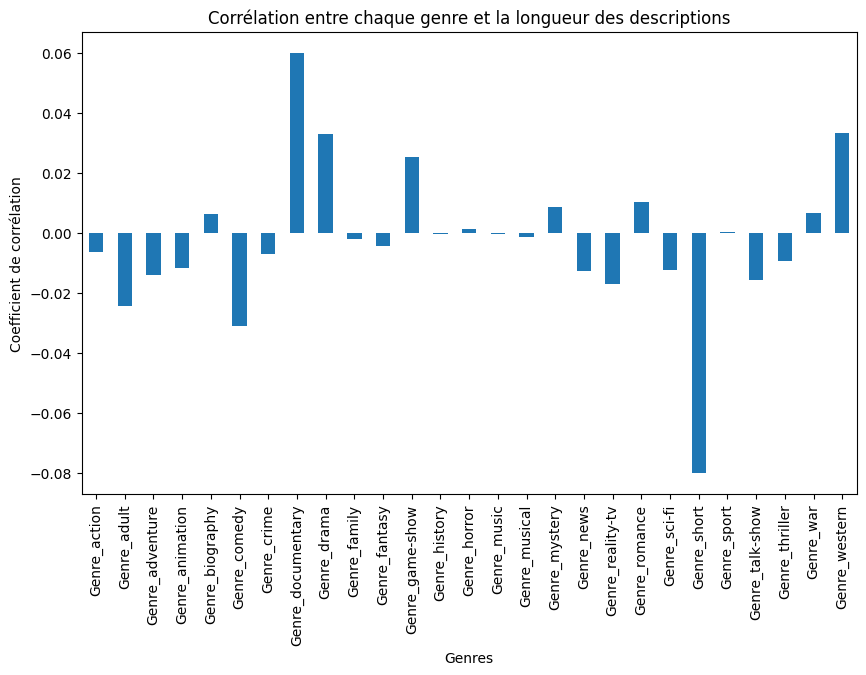

In [33]:

# Créer un graphique en barre des corrélations
correlation_with_length.plot(kind='bar', figsize=(10, 6))
plt.title('Corrélation entre chaque genre et la longueur des descriptions')
plt.ylabel('Coefficient de corrélation')
plt.xlabel('Genres')
plt.show()


Nous voyons donc qu'il y'a une faible relation entre les genres et le nombre de synonymes. Il est donc pas judicieux de supprimer les doublons de description en se basant sur le nombre de synonyme comme je l'avais pensé plus haut. Je vais donc supprimer les doublons en gardant seulement les premiers.

In [34]:
data.drop_duplicates(subset='Description', keep='first', inplace=True)
print(data.shape)
data.head()

(54086, 34)


,ID,Title,Genre,Description,Description_clean,Description_Length,Genre_Synonyms_Count,Genre_action,Genre_adult,Genre_adventure,...,Genre_news,Genre_reality-tv,Genre_romance,Genre_sci-fi,Genre_short,Genre_sport,Genre_talk-show,Genre_thriller,Genre_war,Genre_western
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,Listening conversation doctor parent 10yearold...,53,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,A brother sister past incestuous relationship ...,17,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,As bus empty student field trip Museum Natural...,59,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,To help unemployed father make end meet Edith ...,115,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,The film title refers unrecovered body ground ...,60,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Nous nous retrouvons à présent avec une dataframe de 54086 lignes et 8 colonnes. Aussi, la correlation entre la variable à predire et le nombre de synonymes étant très faible, nous pouvons supprimer cette feature car elle n'est pas pertinente pour la prédiction.

In [35]:
data = data.drop('Genre_Synonyms_Count', axis=1)
data.head()

,ID,Title,Genre,Description,Description_clean,Description_Length,Genre_action,Genre_adult,Genre_adventure,Genre_animation,...,Genre_news,Genre_reality-tv,Genre_romance,Genre_sci-fi,Genre_short,Genre_sport,Genre_talk-show,Genre_thriller,Genre_war,Genre_western
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,Listening conversation doctor parent 10yearold...,53,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,A brother sister past incestuous relationship ...,17,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,As bus empty student field trip Museum Natural...,59,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,To help unemployed father make end meet Edith ...,115,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,The film title refers unrecovered body ground ...,60,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Analyse des sentiments

In [36]:
# Créer une fonction pour calculer le score de sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Appliquer la fonction et ajouter la feature
data['Sentiment'] = data['Description'].apply(get_sentiment)
data.head()

,ID,Title,Genre,Description,Description_clean,Description_Length,Genre_action,Genre_adult,Genre_adventure,Genre_animation,...,Genre_reality-tv,Genre_romance,Genre_sci-fi,Genre_short,Genre_sport,Genre_talk-show,Genre_thriller,Genre_war,Genre_western,Sentiment
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,Listening conversation doctor parent 10yearold...,53,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.192975
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,A brother sister past incestuous relationship ...,17,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-0.125000
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,As bus empty student field trip Museum Natural...,59,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.367500
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,To help unemployed father make end meet Edith ...,115,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.040909
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,The film title refers unrecovered body ground ...,60,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.145536


Nous faisons cette extraction de sentiments à travers la colonne de description initiale afin de maintenir le contenu de l'emotion initiale qu'il y'avait.

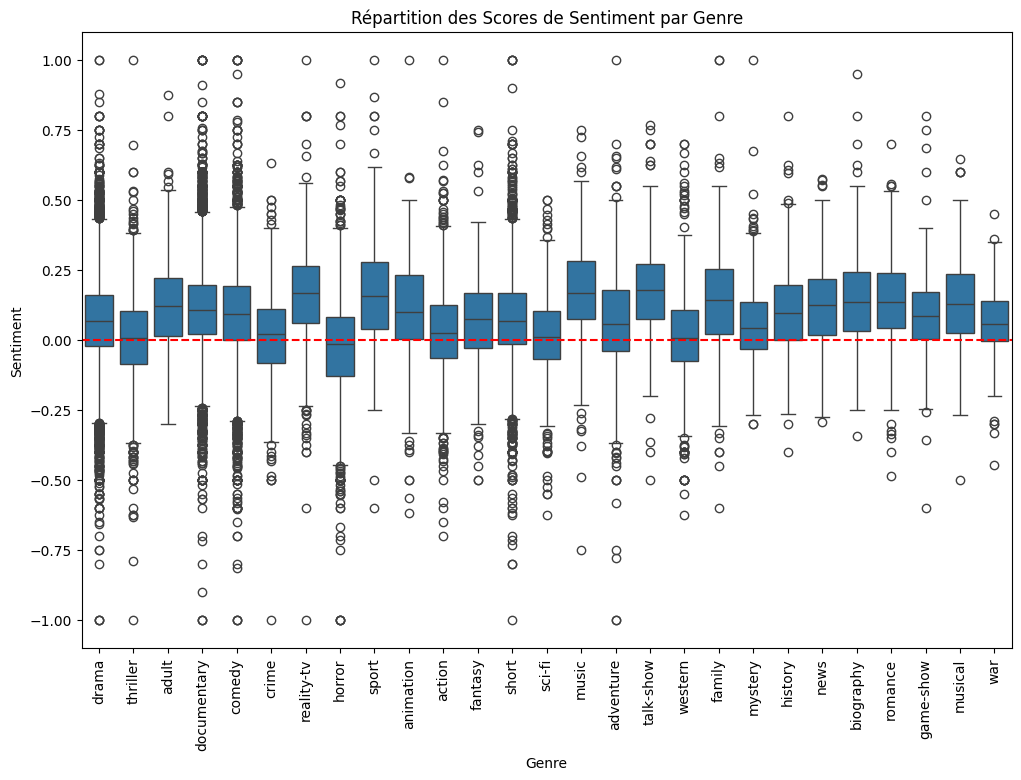

In [37]:
#Visualisation des sentiments en fonction des genres
plt.figure(figsize=(12,8))
sns.boxplot(x='Genre', y='Sentiment', data=data)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)  # Ligne horizontale à y=0
plt.xticks(rotation=90)
plt.title('Répartition des Scores de Sentiment par Genre')
plt.show()

Les genres Comedy, Family, Music, Musical, Adventure, Animation, Game-Show et Romance ont des médianes positives. La majorité des sentimments sont autour du positifs.

### Correlation entre les genres et les sentiments

In [38]:
# Calculer la corrélation entre les colonnes des genres et le nombre de mots
correlation_matrix_sentiment = data[data_one_hot.columns.tolist() + ['Sentiment']].corr()

# Filtrer pour afficher uniquement la corrélation entre les genres et 'Sentiment'
correlation_with_sentiment = correlation_matrix_sentiment['Sentiment'].drop('Sentiment')

# Afficher les résultats
print(correlation_with_sentiment)


Genre_action        -0.047401
Genre_adult          0.025630
Genre_adventure     -0.015751
Genre_animation      0.014181
Genre_biography      0.028266
Genre_comedy         0.024856
Genre_crime         -0.037649
Genre_documentary    0.101637
Genre_drama         -0.054515
Genre_family         0.040744
Genre_fantasy       -0.006478
Genre_game-show      0.005490
Genre_history        0.009360
Genre_horror        -0.132563
Genre_music          0.065686
Genre_musical        0.023151
Genre_mystery       -0.011164
Genre_news           0.018339
Genre_reality-tv     0.062859
Genre_romance        0.036640
Genre_sci-fi        -0.042857
Genre_short         -0.016413
Genre_sport          0.048824
Genre_talk-show      0.051909
Genre_thriller      -0.080377
Genre_war           -0.005813
Genre_western       -0.055049
Name: Sentiment, dtype: float64


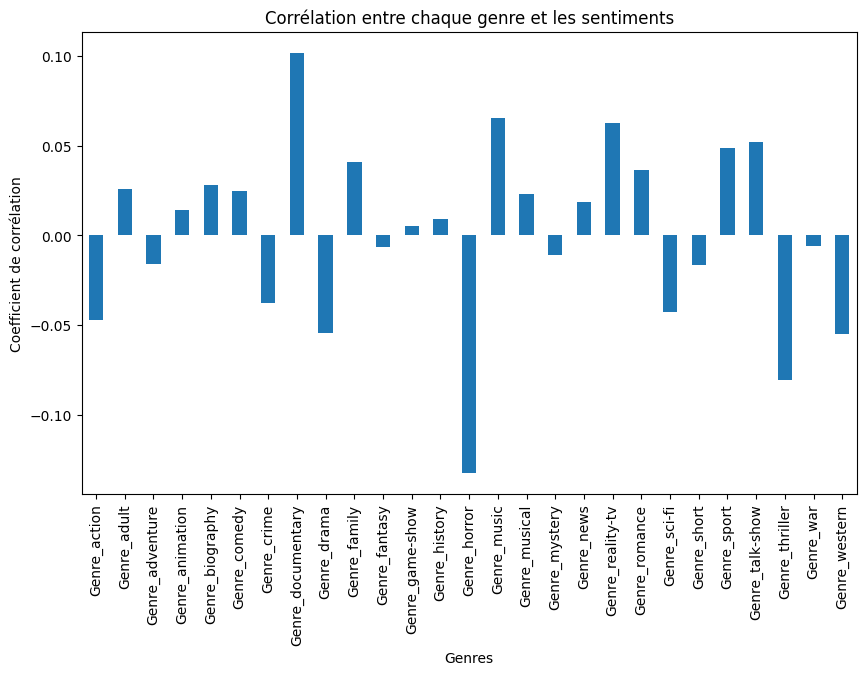

In [39]:

# Créer un graphique en barre des corrélations
correlation_with_sentiment.plot(kind='bar', figsize=(10, 6))
plt.title('Corrélation entre chaque genre et les sentiments')
plt.ylabel('Coefficient de corrélation')
plt.xlabel('Genres')
plt.show()


## Part-of-Speech (POS) Tagging

In [41]:
!pip install textblob

In [42]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [43]:
nltk.download('averaged_perceptron_tagger')
# Créer une fonction pour compter les POS
def pos_count(text, pos_tag):
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    return sum(1 for word, tag in tagged if tag.startswith(pos_tag))

# Ajouter les features pour les noms, verbes et adjectifs
data['Nouns_Count'] = data['Description_clean'].apply(lambda x: pos_count(x, 'NN'))
data['Verbs_Count'] = data['Description_clean'].apply(lambda x: pos_count(x, 'VB'))
data['Adjectives_Count'] = data['Description_clean'].apply(lambda x: pos_count(x, 'JJ'))

data.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,ID,Title,Genre,Description,Description_clean,Description_Length,Genre_action,Genre_adult,Genre_adventure,Genre_animation,...,Genre_short,Genre_sport,Genre_talk-show,Genre_thriller,Genre_war,Genre_western,Sentiment,Nouns_Count,Verbs_Count,Adjectives_Count
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,Listening conversation doctor parent 10yearold...,53,0,0,0,0,...,0,0,0,0,0,0,0.192975,34,5,8
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,A brother sister past incestuous relationship ...,17,0,0,0,0,...,0,0,0,1,0,0,-0.125000,7,2,5
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,As bus empty student field trip Museum Natural...,59,0,1,0,0,...,0,0,0,0,0,0,0.367500,34,7,10
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,To help unemployed father make end meet Edith ...,115,0,0,0,0,...,0,0,0,0,0,0,0.040909,69,19,16
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,The film title refers unrecovered body ground ...,60,0,0,0,0,...,0,0,0,0,0,0,0.145536,36,6,6


In [44]:
# Agréger les données par genre en calculant la moyenne ou la somme des occurrences
data_grouped = data.groupby('Genre')[['Nouns_Count', 'Verbs_Count', 'Adjectives_Count']].mean().reset_index()

# Affichage des premières lignes pour vérifier la table agrégée
print(data_grouped.head())

       Genre  Nouns_Count  Verbs_Count  Adjectives_Count
0     action    33.640518     9.816451          7.855293
1      adult    26.390492     8.772496          8.123939
2  adventure    30.605161     9.449032          8.316129
3  animation    30.734406     9.000000          8.203219
4  biography    37.369811     9.407547          9.335849


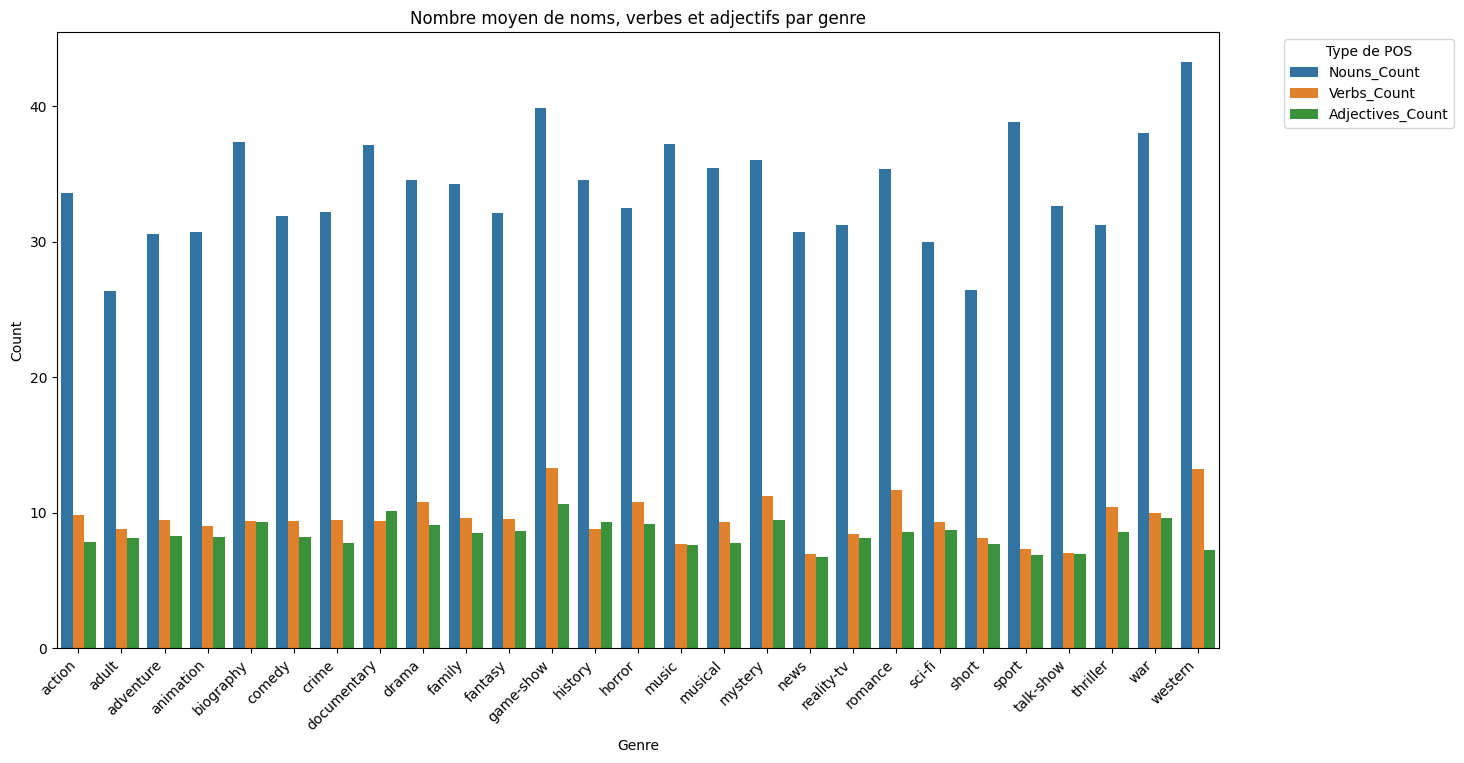

In [45]:
# Définir la figure et la taille
plt.figure(figsize=(15, 8))

# Utiliser melt pour mettre les données en format long (long format) pour Seaborn
data_melted = data_grouped.melt(id_vars='Genre',
                                value_vars=['Nouns_Count', 'Verbs_Count', 'Adjectives_Count'],
                                var_name='POS', value_name='Count')

# Créer le bar plot avec Seaborn
sns.barplot(x='Genre', y='Count', hue='POS', data=data_melted)

# Ajuster les labels pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')
plt.title('Nombre moyen de noms, verbes et adjectifs par genre')
plt.legend(title='Type de POS', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [46]:
# Sélectionner uniquement les colonnes avec les genres et les counts de POS (Nouns, Verbs, Adjectives)
genre_columns = [col for col in data.columns if col.startswith('Genre_')]
pos_columns = ['Nouns_Count', 'Verbs_Count', 'Adjectives_Count']

# Calculer la matrice de corrélation entre les genres et les POS counts
correlation_matrix_pos = data[genre_columns + pos_columns].corr()

# Afficher uniquement les corrélations entre genres et POS counts
genre_pos_correlations = correlation_matrix_pos.loc[genre_columns, pos_columns]

print(genre_pos_correlations)


                   Nouns_Count  Verbs_Count  Adjectives_Count
Genre_action         -0.001074     0.000835         -0.023342
Genre_adult          -0.030286    -0.012702         -0.011525
Genre_adventure      -0.015047    -0.004723         -0.009954
Genre_animation      -0.011535    -0.009006         -0.009494
Genre_biography       0.009694    -0.003101          0.004366
Genre_comedy         -0.029638    -0.019498         -0.037971
Genre_crime          -0.006007    -0.003434         -0.015310
Genre_documentary     0.073981    -0.024291          0.100557
Genre_drama           0.017050     0.072848          0.018285
Genre_family          0.002273    -0.002771         -0.006868
Genre_fantasy        -0.005145    -0.002419         -0.002431
Genre_game-show       0.014111     0.025606          0.014923
Genre_history         0.002018    -0.008056          0.004156
Genre_horror         -0.010538     0.025104          0.008082
Genre_music           0.015422    -0.029026         -0.021072
Genre_mu

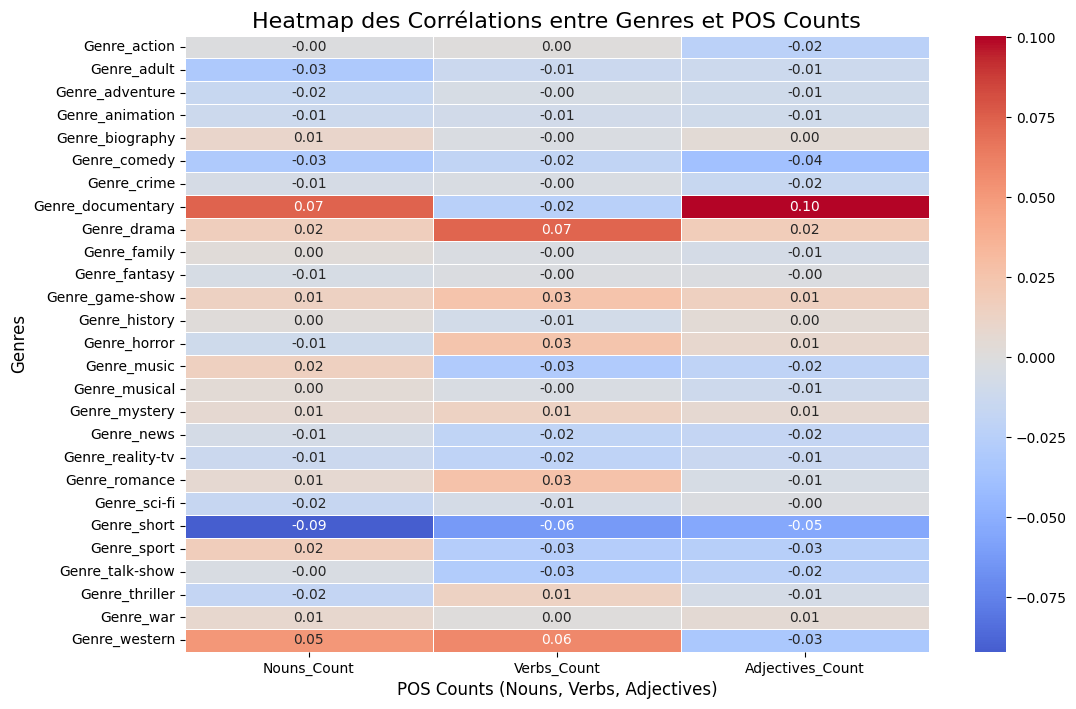

In [47]:
# Créer la heatmap des corrélations entre genres et POS counts
plt.figure(figsize=(12, 8))  # Ajuster la taille de la figure
sns.heatmap(genre_pos_correlations, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)

# Ajouter un titre et des labels
plt.title('Heatmap des Corrélations entre Genres et POS Counts', fontsize=16)
plt.xlabel('POS Counts (Nouns, Verbs, Adjectives)', fontsize=12)
plt.ylabel('Genres', fontsize=12)

# Afficher la heatmap
plt.show()


## Nombre de Noms Propres (NER - Named Entity Recognition)

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

# Créer une fonction pour compter les entités nommées
def named_entity_count(text):
    doc = nlp(text)
    return len([ent for ent in doc.ents])

# Appliquer la fonction
data['Named_Entities_Count'] = data['Description_clean'].apply(named_entity_count)
